In [275]:
## tutorial from https://github.com/cytoscape/cytoscape-automation/blob/master/for-scripters/Python/advanced-cancer-networks-and-data.ipynb

import os
import sys
from time import sleep
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from py2cytoscape import cyrest
from IPython.display import Image
%matplotlib inline

In [276]:
cytoscape=cyrest.cyclient()
cytoscape.version()

apiVersion v1
cytoscapeVersion 3.7.2


In [282]:
cytoscape.session.new()

In [278]:
## read table
fileName="Francavilla2017CellRep.tsv"
fileRead=pd.read_table(fileName,sep="\t")
fileRead.head()

,UniProt,Gene name,Modified sequence,AA position,EOC,FTE,OSE,EOC vs FTE,EOC vs OSE,Adj p-value,Cluster
0,O15439,ABCC4,_KDNEESEQPPVPGT(ph)PTLR_,T646,25.72,27.83,28.18,-2.11,-2.46,0.031600,A
1,Q9UKV3,ACIN1,_SSSISEEKGDS(ph)DDEKPR_,S118,24.82,25.54,22.18,-0.72,2.64,0.021500,B
2,Q9UKV3,ACIN1,_AAKLS(ph)EGS(ph)QPAEEEEDQETPSR_,S145,26.22,25.02,23.24,1.21,2.98,0.010800,C
3,Q9UKV3,ACIN1,_SKS(ph)PS(ph)PPRLTEDR_,S290,26.00,23.46,22.82,2.53,3.17,0.020600,C
4,Q9UKV3,ACIN1,_RLS(ph)QPESAEK_,S614,30.20,26.98,25.94,3.23,4.27,0.000913,C


In [279]:
UniprotIds=",".join(list(set(fileRead['UniProt'])))

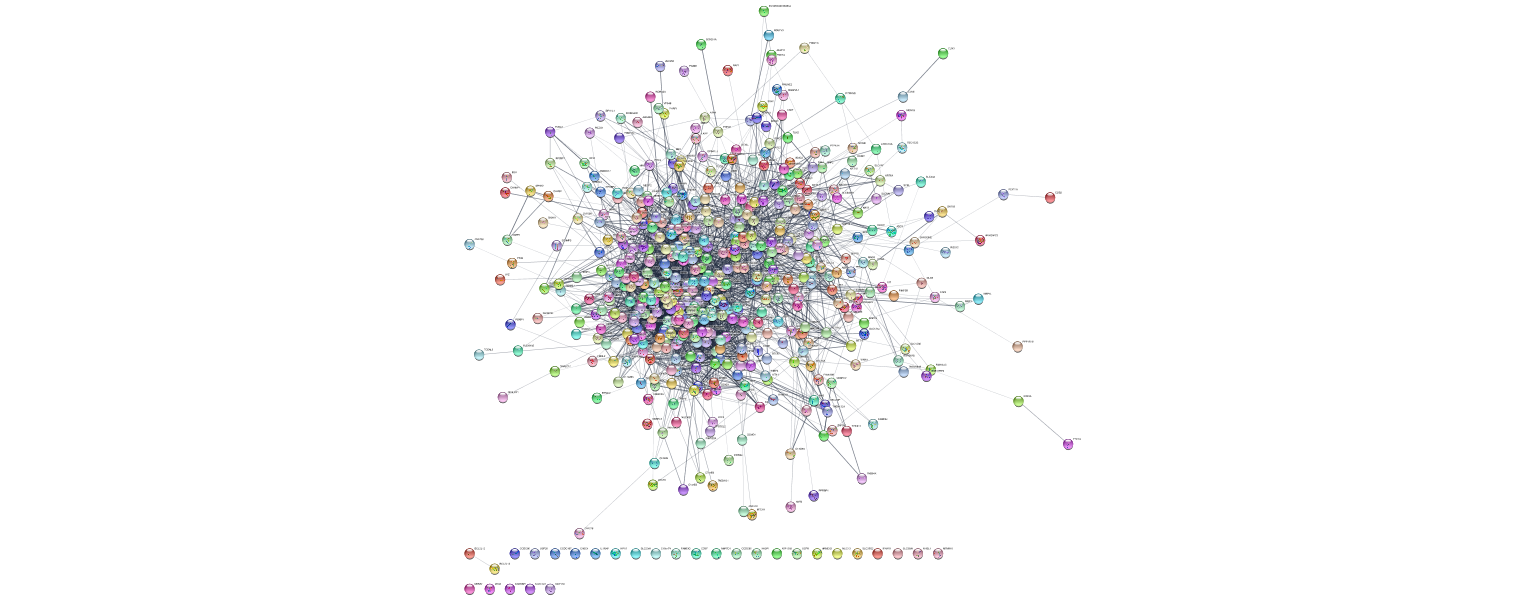

In [283]:
from py2cytoscape.cyrest.base import api
## create the string network with the uniprot ids
api(namespace="string",command="protein query",PARAMS={"cutoff": "0.4",
                                                      "limit": "0",
                                                      "newNetName": "EOC Network",
                                                      "query": UniprotIds,
                                                      "species": "homo sapiens",
                                                      "taxonID": "9606"})
sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

In [284]:
family_type=list(set(cytoscape.table.getTable(columns=['target::family'],table='node')['target::family']))
family_colors='grey green red blue'.split(" ")
family_type

[None, 'Kinase', 'Ion Channel', 'GPCR']

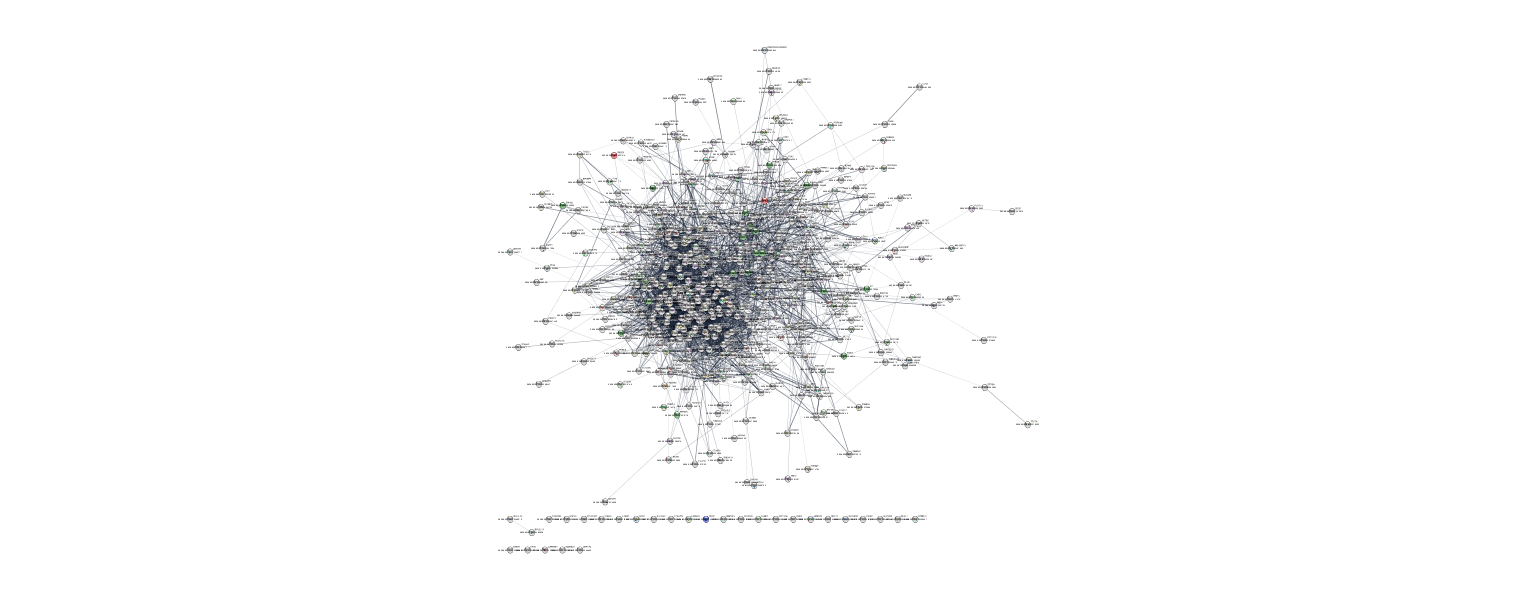

In [285]:
## mapping with discrete color
NODE_FILL_COLOR=cytoscape.vizmap.mapVisualProperty(visualProperty='NODE_FILL_COLOR',mappingType="discrete",\
                                                   mappingColumn='target::family', discrete=[family_type,family_colors])
cytoscape.vizmap.update_style(title="STRING style v1.5 - EOC Network",mappings=[NODE_FILL_COLOR])
cytoscape.vizmap.apply(styles="STRING style v1.5 - EOC Network")
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

In [95]:
##TODO: not working.. check again.......

api(namespace='filter', command="create", PARAMS={
  "name" : "Default filter",
  "transformers" : [ {
    "id" : "org.cytoscape.CompositeFilter",
    "parameters" : {
      "type" : "ALL"
    },
    "transformers" : [ {
      "id" : "org.cytoscape.ColumnFilter",
      "parameters" : {
        "predicate" : "IS",
        "criterion" : "KINASE",
        "caseSensitive" : "false",
        "type" : "nodes",
        "anyMatch" : "true",
        "columnName" : "target::family"
      }
    } ]
  } ]
})
api(namespace='filter',command='apply',PARAMS={'name':'Default filter',"network": "current"})
sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

In [286]:
## select each entry for each protein

protSet=set(fileRead['UniProt'])
print(len(protSet))
index_prot=[list(fileRead['UniProt']).index(each) for each in protSet]
selected_set=fileRead.iloc[index_prot]


541


In [287]:
## import data table in the network

cytoscape.table.loadTableData(selected_set,df_key='UniProt',table="node",table_key_column="query term")


b''

#0000ff #fffefe #ff0000


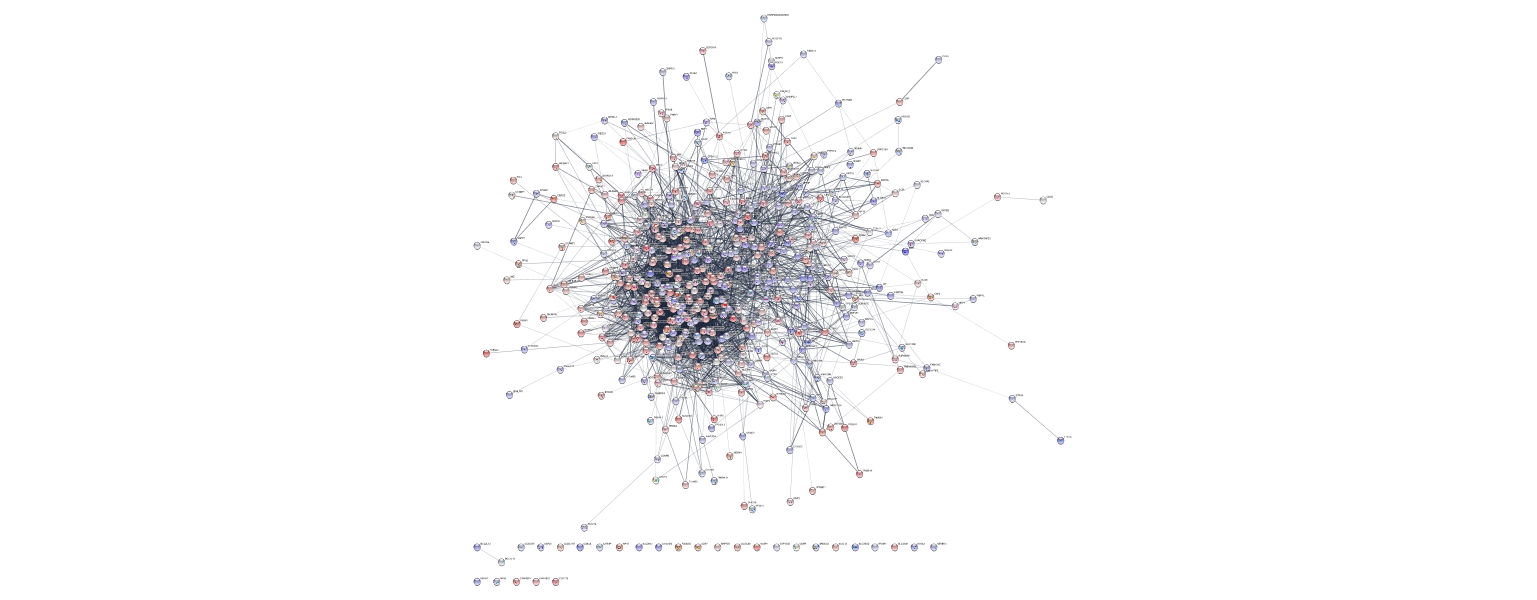

In [288]:
#continous column mapping


### get table with expr values
logFC = cytoscape.table.getTable(columns=['EOC vs FTE'],table='node')
logFC.head()


### define min and max and corresponding colors
min_expr = min(logFC.dropna()['EOC vs FTE'].tolist())
max_expr = max(logFC.dropna()['EOC vs FTE'].tolist())
max_expr_mapping=max([abs(min_expr),abs(max_expr)])
min_expr_mapping=max_expr_mapping*-1.0
cmap = matplotlib.cm.get_cmap("bwr")
norm = matplotlib.colors.Normalize(vmin=min_expr_mapping, vmax=max_expr_mapping)
min_color=matplotlib.colors.rgb2hex(cmap(norm(min_expr_mapping)))
center_color=matplotlib.colors.rgb2hex(cmap(norm(0)))
max_color=matplotlib.colors.rgb2hex(cmap(norm(max_expr_mapping)))
print(min_color, center_color, max_color)

NODE_FILL_COLOR=cytoscape.vizmap.mapVisualProperty(visualProperty='NODE_FILL_COLOR',mappingType="continuous",\
                                                   mappingColumn='EOC vs FTE',lower=[min_expr_mapping,min_color],\
                                                   center=[0.0,center_color],upper=[max_expr_mapping,max_color])
cytoscape.vizmap.update_style(title="STRING style v1.5 - EOC Network",mappings=[NODE_FILL_COLOR])
cytoscape.vizmap.apply(styles="STRING style v1.5 - EOC Network")
sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

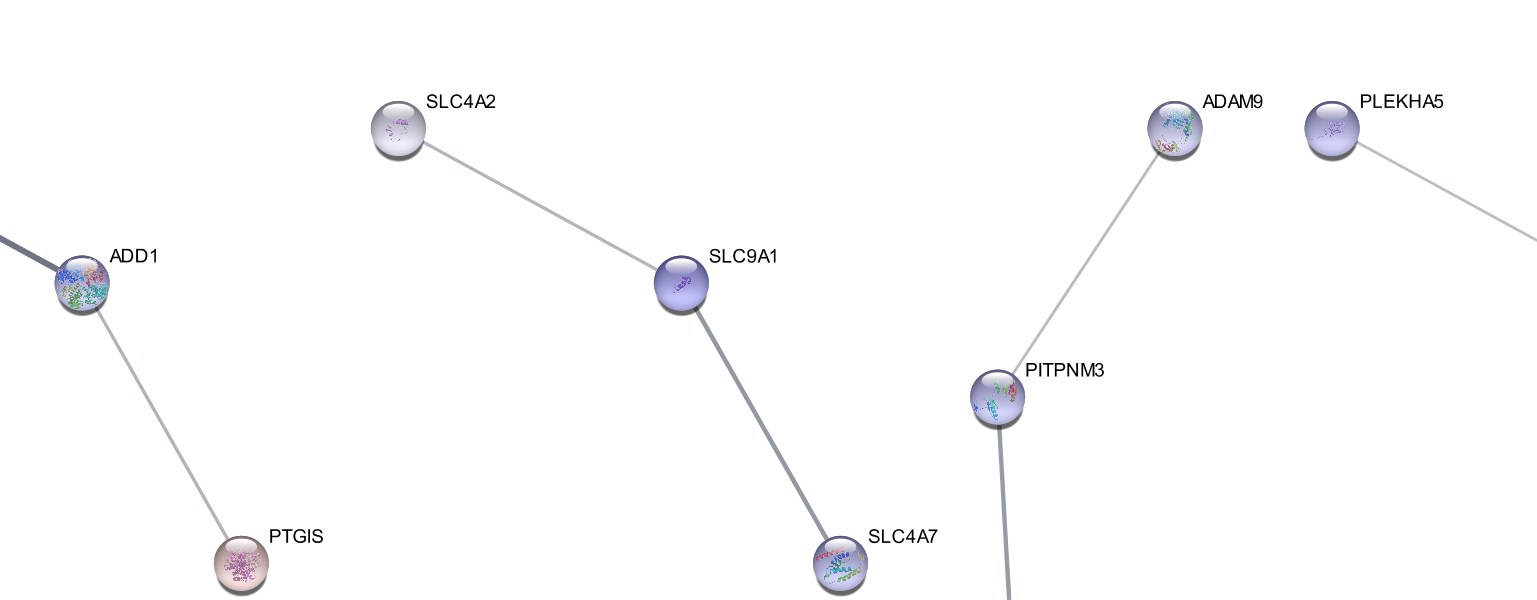

In [289]:
api(namespace='cluster', command='mcl', PARAMS={'attribute':'stringdb::score', 'inflation_parameter':'4', 'showUI':'true'})
sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)


In [290]:
## save the session
cytoscape.session.save_as(session_file="stringApp_tutorial_ex3")

In [291]:
## now for each cluster create network and do string enrichment
cluster_names=cytoscape.table.getTable(columns=['__mclCluster'],table='node').sort_values(['__mclCluster'],ascending=[1])
cluster_names.head()

,__mclCluster
9606.ENSP00000307863,1.0
9606.ENSP00000304903,1.0
9606.ENSP00000260210,1.0
9606.ENSP00000244020,1.0
9606.ENSP00000452123,1.0


In [292]:
## to get the suid for the main network
clust_suid="SUID:"+str(cytoscape.network.get_attribute(columnList="SUID")[0]['SUID'])
clust_suid

'SUID:77889'

In [293]:
cytoscape.network.deselect(network=clust_suid, nodeList="all")

for clus in list(set(cluster_names['__mclCluster']))[1:8]:
    gene_list=cluster_names['__mclCluster'][cluster_names['__mclCluster']==clus].index.tolist()
    if len(gene_list)>0:
        print(len(gene_list))
        ## select the sub cluster and create a network
        cytoscape.network.select(nodeList="name:"+",".join(gene_list),network=clust_suid)
        cytoscape.network.create(nodeList="selected",source=clust_suid)
        ## now apply string enrichment on the selected network
        api(namespace='string',command='make string')
        ##retrieve enrichment
        api(namespace="string",command="retrieve enrichment")

        ## deselect all the nodes before another loop
        cytoscape.network.deselect(network=clust_suid, nodeList="all")
        
        
api(namespace="string",command="show enrichment")
        

47
30
20
13
11
10
8


In [294]:
## save the session
cytoscape.session.save_as(session_file="tringApp_tutorial_ex3")